# Case Study 3 : Analyzing data from MovieLens

**Due Date: Due Date: October 31, 2024 by 5:59pm**


## The MovieLens data sets


http://grouplens.org/datasets/movielens/



In [46]:
from IPython.lib.display import YouTubeVideo

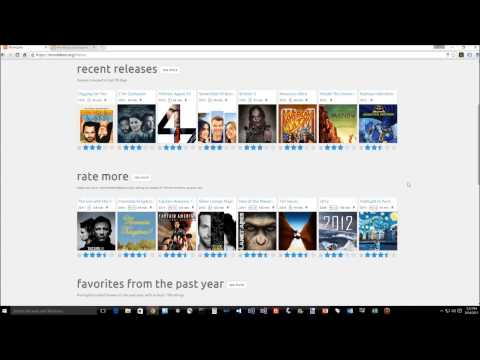

In [47]:
YouTubeVideo('4tW9HY0Q460')

**TEAM Members:** 

Please EDIT this cell and add the names of all the team members in your team:

    1. Kobe Richards
    
    2. Vikas Kumar Shukla
    
    3. Ujjwal Pandit

    4. Vaibhav Chetan Chavan
 
 *Group Name: Boo-siness Analysts*

**Please note that there will be a survey after the case study, where you will have to answer questions about other group members’ contributions anonymously.**

**Desired outcome of the case study.**
* In this case study we will look at the MovieLens 1M Data Set.
    * It contains data about users and how they rate movies.
* The idea is to *analyze* the data set, make *conjectures*, support or refute those conjectures with *data*, and *tell a story* about the data!
    
**Required Readings:** 
* Chapter 2 (only the section on the MovieLens 1M Data Set), Chapter 5, Chapter 6,
and Chapter 8 of the book [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do)  (available from the WPI library as an e-book).
* If you want your code to be really compact then you might want to also look into the pivot_table method of Panda's DataFrame, though there are many other ways to complete the case study!




# Problem 1 (20 points total): 

## (10 points) Importing the MovieLens data set and merging it into a single Pandas DataFrame

* Download the 1 million ratings data set from http://grouplens.org/datasets/movielens/ (though if you are feeling adventerous you can download the 10 million ratings file instead)
* Merge all of the data into a single Pandas DataFrame
* Store the data into an HDF5 file.

## (10 points) Report some basic details of the data you collected.  For example:

*  How many movies have an average rating over 4.5 overall?
*  How many movies have an average rating over 4.5 among men?  How about women?
*  How many movies have an *median* rating over 4.5 among men over age 30?  How about women over age 30?
*  What are the ten most popular movies?
    * Choose what you consider to be a reasonable defintion of "popular".
    * Be perpared to defend this choice.
*  Make some conjectures about how easy various groups are to please? Support your answers with data!  
    *  For example, one might conjecture that people between the ages of 1 and 10 are the easiest to please since they are all young children.  This conjecture may or may not be true, but how would you support or disprove either conclusion with with data?
    *  Be sure to come up with your own conjectures and support them with data!


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Load individual data for users, movies, and ratings
users = pd.read_csv(r"C:\Users\kober\School Work\DS\DS 501\casestudy_3\dataset\ml-1m\users.dat", sep='::', engine='python', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])
movies = pd.read_csv(r"C:\Users\kober\School Work\DS\DS 501\casestudy_3\dataset\ml-1m\movies.dat", sep='::', engine='python', encoding='ISO-8859-1', names=['MovieID', 'Title', 'Genres'])
ratings = pd.read_csv(r"C:\Users\kober\School Work\DS\DS 501\casestudy_3\dataset\ml-1m\ratings.dat", sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

# Merge data into a single dataframe and store as an HDF5 file
merged_df = ratings.merge(users, on='UserID').merge(movies, on='MovieID')
merged_df.to_hdf('ml_1m.h5', key='df',mode='w')
merged_df.head()

UserID  MovieID  Rating  Timestamp Gender  Age  Occupation Zip-code  \
0       1     1193       5  978300760      F    1          10    48067   
1       1      661       3  978302109      F    1          10    48067   
2       1      914       3  978301968      F    1          10    48067   
3       1     3408       4  978300275      F    1          10    48067   
4       1     2355       5  978824291      F    1          10    48067   

                                    Title                        Genres  
0  One Flew Over the Cuckoo's Nest (1975)                         Drama  
1        James and the Giant Peach (1996)  Animation|Children's|Musical  
2                     My Fair Lady (1964)               Musical|Romance  
3                  Erin Brockovich (2000)                         Drama  
4                    Bug's Life, A (1998)   Animation|Children's|Comedy

In [49]:
# Overall average ratings above 4.5
avg_movies = merged_df.groupby('Title')['Rating'].mean()
avg_movie_count = avg_movies[avg_movies > 4.5].count()
print('Overall average ratings above 4.5:', avg_movie_count)

# Average ratings by gender
male_ratings = merged_df[merged_df['Gender'] == 'M'].groupby('Title')['Rating'].mean()
avg_movies_male = male_ratings[male_ratings > 4.5].count()

female_ratings = merged_df[merged_df['Gender'] == 'F'].groupby('Title')['Rating'].mean()
avg_movies_female = female_ratings[female_ratings > 4.5].count()

print('Average ratings above 4.5 (men):', avg_movies_male)
print('Average ratings above 4.5 (women):', avg_movies_female)

# Median ratings by gender and age group (over 30)
men_over_30 = merged_df[(merged_df['Gender'] == 'M') & (merged_df['Age'] > 30)].groupby('Title')['Rating'].median()
median_movies_men = men_over_30[men_over_30 > 4.5].count()

women_over_30 = merged_df[(merged_df['Gender'] == 'F') & (merged_df['Age'] > 30)].groupby('Title')['Rating'].median()
median_movies_women = women_over_30[women_over_30 > 4.5].count()

print('\nMedian ratings above 4.5 (men over 30):', median_movies_men)
print('Median ratings above 4.5 (women over 30):', median_movies_women)

# Top 10 most popular movies (weighted average rating)
# Defining "popularity" as the number of ratings
# Calculate the mean rating across all movies
C = merged_df['Rating'].mean()

# Set a minimum number of ratings to consider a movie "popular"
# For instance, here we use the 90th percentile of the number of ratings as the threshold
m = merged_df.groupby('MovieID')['Rating'].count().quantile(0.90)

# Calculate the number of ratings and average rating for each movie
movie_stats = merged_df.groupby('MovieID').agg(
    num_ratings=('Rating', 'count'),
    avg_rating=('Rating', 'mean')
).reset_index()

# Only consider movies with more than 'm' ratings for the popularity calculation
qualified_movies = movie_stats[movie_stats['num_ratings'] >= m].copy()

# Calculate the weighted rating
qualified_movies['weighted_rating'] = (
    (qualified_movies['num_ratings'] / (qualified_movies['num_ratings'] + m)) * qualified_movies['avg_rating'] +
    (m / (qualified_movies['num_ratings'] + m)) * C
)

# Get the top 10 movies based on weighted rating
top_popular_movies = qualified_movies.nlargest(10, 'weighted_rating').merge(
    movies[['MovieID', 'Title']], on='MovieID'
)

print("\nTop 10 most popular movies based on weighted rating:")
print(top_popular_movies[['Title', 'num_ratings', 'avg_rating', 'weighted_rating']])

# Conjectures
# Example conjecture: Younger people (under age 30) are easier to please.
younger_group_ratings = merged_df[merged_df['Age'] < 30].groupby('MovieID')['Rating'].mean()
avg_rating_younger_group = younger_group_ratings.mean()

print(f"\nAverage rating given by users under age 30: {avg_rating_younger_group:.2f}")

# Example conjecture: Men are easier to please than women.
avg_rating_men = merged_df[merged_df['Gender'] == 'M']['Rating'].mean()
avg_rating_women = merged_df[merged_df['Gender'] == 'F']['Rating'].mean()

print(f"Average rating given by men: {avg_rating_men:.2f}")
print(f"Average rating given by women: {avg_rating_women:.2f}")

Overall average ratings above 4.5: 21
Average ratings above 4.5 (men): 23
Average ratings above 4.5 (women): 51

Median ratings above 4.5 (men over 30): 86
Median ratings above 4.5 (women over 30): 149

Top 10 most popular movies based on weighted rating:
                                       Title  num_ratings  avg_rating  \
0           Shawshank Redemption, The (1994)         2227    4.554558   
1                      Godfather, The (1972)         2223    4.524966   
2                    Schindler's List (1993)         2304    4.510417   
3  Star Wars: Episode IV - A New Hope (1977)         2991    4.453694   
4             Raiders of the Lost Ark (1981)         2514    4.477725   
5                 Usual Suspects, The (1995)         1783    4.517106   
6                    Sixth Sense, The (1999)         2459    4.406263   
7                     American Beauty (1999)         3428    4.317386   
8           Silence of the Lambs, The (1991)         2578    4.351823   
9             

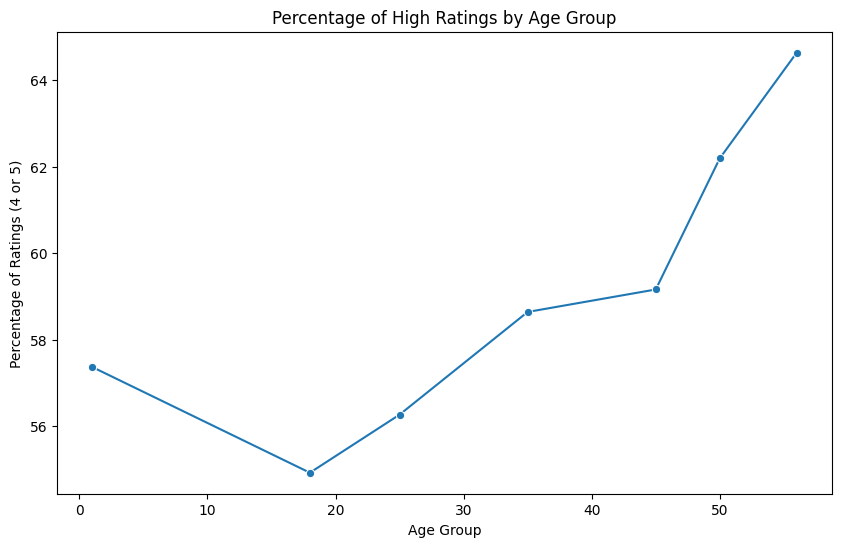

In [50]:
# Calculate the percentage of high ratings (e.g., 4 and 5) by age group
age_high_ratings = merged_df[merged_df['Rating'] >= 4].groupby('Age')['Rating'].count()
age_total_ratings = merged_df.groupby('Age')['Rating'].count()
age_high_rating_percent = (age_high_ratings / age_total_ratings * 100).fillna(0)

# Plot percentage of high ratings by age
plt.figure(figsize=(10, 6))
sns.lineplot(x=age_high_rating_percent.index, y=age_high_rating_percent.values, marker='o')
plt.title('Percentage of High Ratings by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage of Ratings (4 or 5)')
plt.show()

# Problem 2 (20 points total): Expand our investigation to histograms

**An obvious issue with any inferences drawn from Problem 1 is that we did not consider how many times a movie was rated.** 
* (2 points) Plot a histogram of the ratings of all movies.
* (2 points) Plot a histogram of the *number* of ratings each movie recieved.
* (2 points) Plot a histogram of the *average rating* for each movie.
* (6 points) Plot a histogram of the *average rating* for movies which are rated more than 100 times.
    * What do you observe about the tails of the histogram where you use all the movies versus the one where you only use movies rated more than 100 times?
    * Which highly rated movies would you trust are actually good?  Those rated more than 100 times or those rated less than 100 times?
* (8 points) Make some conjectures about the distribution of ratings? Support your answers with data!  
    *  For example, what age range do you think has more extreme ratings?  Do you think children are more or less likely to rate a movie 1 or 5?
    *  Be sure to come up with your own conjectures and support them with data!

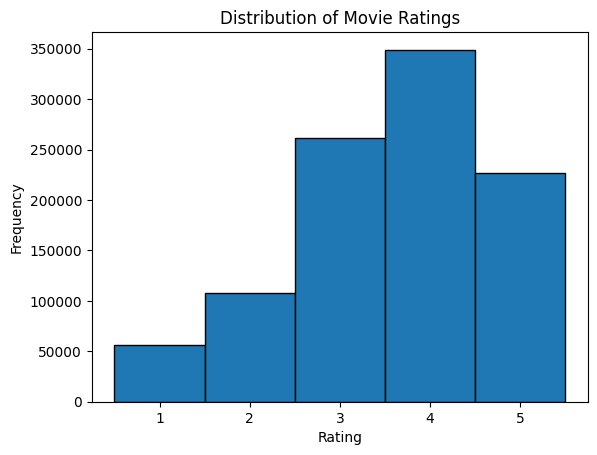

In [51]:
# Distribution of movie ratings
plt.hist(merged_df['Rating'], bins=[1,2,3,4,5,6], edgecolor='black', align='left')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks([1,2,3,4,5])
plt.show()

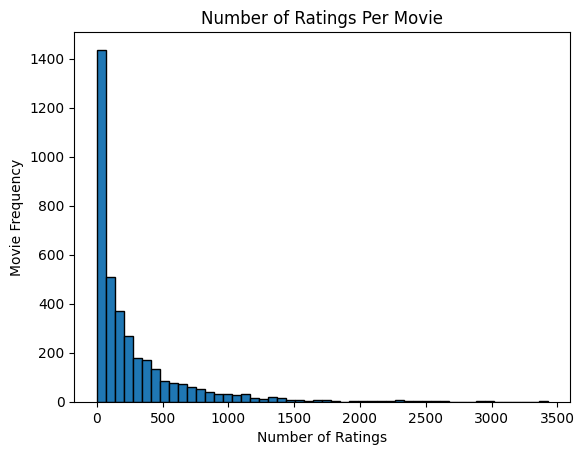

In [52]:
# Number of ratings per movie
ratings_per_movie = merged_df.groupby('Title').size()
plt.hist(ratings_per_movie, bins=50, edgecolor='black')
plt.title('Number of Ratings Per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Frequency')
plt.show()

In [53]:
# Average ratings per movie
avg_movie_ratings = merged_df.groupby('Title')['Rating'].mean()
plt.hist(avg_movie_ratings, bins=np.arange(1, 5.1, 0.1), edgecolor='black')
plt.title('Average Ratings Per Movie')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

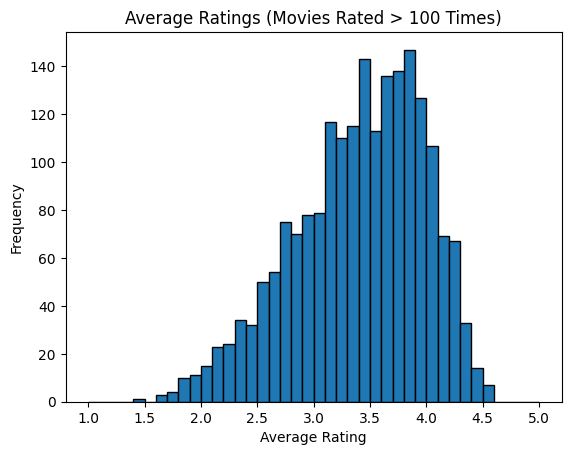

In [54]:
# Average ratings for movies rated more than 100 times
movies_rated_100_plus = avg_movie_ratings[ratings_per_movie > 100]
plt.hist(movies_rated_100_plus, bins=np.arange(1, 5.1, 0.1), edgecolor='black')
plt.title('Average Ratings (Movies Rated > 100 Times)')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

**Observations of the Tails of the Histograms**

*All Movies*

The ratings show a wide spread, with most movies clustered around an average score of 3.0-4.0. However, there is a noticeable number of movies with very high (4.5-5.0) and very low (1.0-1.5) average ratings, indicating a higher likelihood of extremes when fewer ratings are considered in the analysis.

*Movies Rated More Than 100 Times*

This distribution closely resembles the overall rating spread, also centering around averages of 3.0-4.0. Unlike the first histogram, the histogram of movies with more than 100 ratings shows fewer movies with extreme averages below 1.5 or above 4.5, suggesting a more balanced distribution when movies are rated frequently.

**Trustworthiness of Highly Rated Movies**

Movies rated more than 100 times are likely more trustworthy in terms of quality. The more ratings a movie has, the less likely it is that a high average rating is due to just a few extremely positive (or negative) reviews. Therefore, movies with an average rating above 4.0 in the second histogram (movies rated more than 100 times) are more reliable indicators of broad audience appreciation than those in the first histogram with fewer ratings.

**Do younger audiences (ages 1-18) give more extreme ratings?**

Younger viewers might give more extreme ratings compared to older audiences.

In [55]:
young_viewers = merged_df[merged_df['Age'] <=18]
extreme_ratings_young = young_viewers['Rating'].value_counts(normalize=True)[[1, 5]].sum()

other_viewers = merged_df[merged_df['Age'] > 18]
extreme_ratings_other = other_viewers['Rating'].value_counts(normalize=True)[[1, 5]].sum()

print('Proportion of extreme rating for young viewers:', extreme_ratings_young)
print('Proportion of extreme rating for other viewers:', extreme_ratings_other)

Proportion of extreme rating for young viewers: 0.297328075844496
Proportion of extreme rating for other viewers: 0.27844658767616426


**Do movies in certain genres receive more extreme ratings than others?**

Some genres might attract polarizing opinions, leading to a higher proportion of extreme ratings.

In [56]:
merged_df_exploded = merged_df.copy()
merged_df_exploded['Genres'] = merged_df_exploded['Genres'].str.split('|')
merged_df_exploded = merged_df_exploded.explode('Genres')

genre_extreme_ratings = merged_df_exploded[merged_df_exploded['Rating'].isin([1, 5])].groupby('Genres').size() / merged_df_exploded.groupby('Genres').size()
genre_extreme_ratings = genre_extreme_ratings.dropna().sort_values(ascending=False)

print('Genres with the highest proportion of extreme ratings:', genre_extreme_ratings)

Genres with the highest proportion of extreme ratings: Genres
Film-Noir      0.400800
War            0.377515
Documentary    0.373578
Drama          0.306725
Crime          0.303139
Musical        0.303084
Animation      0.297785
Mystery        0.293046
Western        0.291786
Sci-Fi         0.276508
Horror         0.276098
Thriller       0.271452
Children's     0.269429
Action         0.266911
Comedy         0.266829
Adventure      0.262047
Romance        0.260339
Fantasy        0.257734
dtype: float64


**Are users who rate fewer movies more likely to give extreme ratings?**

Users who rate only a few movies may rate only the ones they strongly liked or disliked, resulting in a higher proportion of extreme ratings.

In [57]:
user_ratings_count = merged_df.groupby('UserID').size()
occasional_raters = user_ratings_count[user_ratings_count < 100].index
frequent_raters = user_ratings_count[user_ratings_count >= 100].index

occasional_extreme_ratings = merged_df[(merged_df['UserID'].isin(occasional_raters)) & (merged_df['Rating'].isin([1, 5]))].shape[0] / len(merged_df[merged_df['UserID'].isin(occasional_raters)])
frequent_extreme_ratings = merged_df[(merged_df['UserID'].isin(frequent_raters)) & (merged_df['Rating'].isin([1, 5]))].shape[0] / len(merged_df[merged_df['UserID'].isin(frequent_raters)])

print('Proportion of extreme ratings by occasional raters:', occasional_extreme_ratings)
print('Proportion of extreme ratings by frequent raters:', frequent_extreme_ratings)

Proportion of extreme ratings by occasional raters: 0.3455106698843088
Proportion of extreme ratings by frequent raters: 0.2710403138432342


# Problem 3: (20 points total)
## Correlation:  Men versus women

Let look more closely at the relationship between the pieces of data we have.

* (2 points) Make a scatter plot of men versus women and their mean rating for every movie.
* (2 points) Make a scatter plot of men versus women and their mean rating for movies rated more than 200 times.
* (6 points) Compute the *correlation coefficent* between the ratings of men and women.
    * What do you observe?
    * Are the ratings similiar or not? Support your answer with data!
* (10 points) Conjecture under what circumstances the rating given by one gender can be used to predict the rating given by the other gender.
    * For example, are men and women more similar when they are younger or older?
    * Be sure to come up with your own conjectures and support them with data!

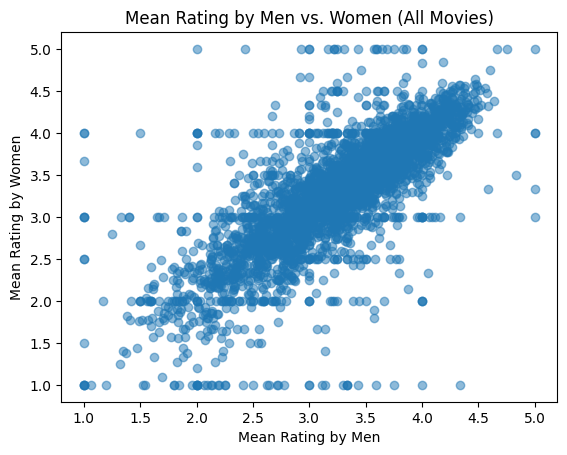

In [58]:
# Calculate mean ratings by gender for each movie
mean_ratings_gender = merged_df.groupby(['Title', 'Gender'])['Rating'].mean().unstack()

# Scatter plot for mean ratings by men vs. women for every movie
plt.scatter(mean_ratings_gender['M'], mean_ratings_gender['F'], alpha=0.5)
plt.xlabel('Mean Rating by Men')
plt.ylabel('Mean Rating by Women')
plt.title('Mean Rating by Men vs. Women (All Movies)')
plt.show()

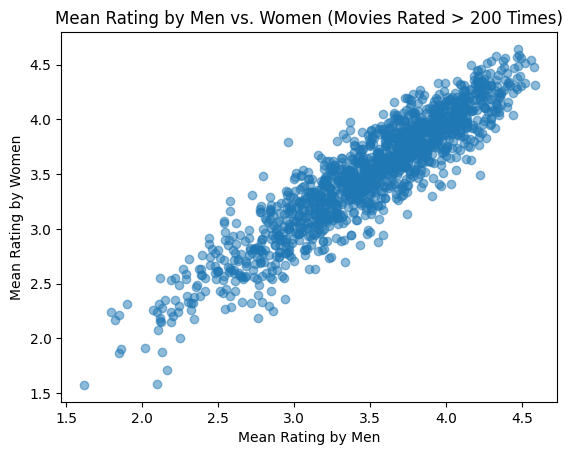

In [59]:
# Filter for movies rated more than 200 times
ratings_per_movie = merged_df.groupby('Title').size()
movies_200_plus = ratings_per_movie[ratings_per_movie > 200].index
mean_ratings_200_plus = mean_ratings_gender.loc[movies_200_plus]

# Scatter plot for mean ratings by men vs. women for movies rated more than 200 times
plt.scatter(mean_ratings_200_plus['M'], mean_ratings_200_plus['F'], alpha=0.5)
plt.xlabel('Mean Rating by Men')
plt.ylabel('Mean Rating by Women')
plt.title('Mean Rating by Men vs. Women (Movies Rated > 200 Times)')
plt.show()

In [60]:
# Calculate the correlation coefficient between men’s and women’s ratings
correlation_all_movies = mean_ratings_gender['M'].corr(mean_ratings_gender['F'])
correlation_200_plus = mean_ratings_200_plus['M'].corr(mean_ratings_200_plus['F'])

print('Correlation coefficient (all movies):', correlation_all_movies)
print('Correlation coefficient (movies rated > 200 times):', correlation_200_plus)

Correlation coefficient (all movies): 0.7631898908583271
Correlation coefficient (movies rated > 200 times): 0.918361385702666


## Observation of Correlation Coefficients
**All Movies:** The correlation coefficient of **0.76** indicates a **moderately strong positive correlation** between the ratings given by men and women for all movies. However, this still leaves room for variation, as some movies may appeal differently to each gender.

**Movies Rated More Than 200 Times:** The correlation coefficient of **0.92** is **very high**, indicating a strong positive correlation for movies with more than 200 ratings. This high correlation suggests that popular movies (those with many ratings) tend to have similar ratings from both genders, reinforcing the observation from the scatter plot.

In [61]:
# Define age groups
age_groups = merged_df['Age'].unique()
age_gender_correlations = {}

# Calculate correlation between men’s and women’s ratings for each age group
for age in age_groups:
    age_group_ratings = merged_df[merged_df['Age'] == age].groupby(['Title', 'Gender'])['Rating'].mean().unstack()
    if not age_group_ratings['M'].isna().all() and not age_group_ratings['F'].isna().all():  # Exclude empty groups
        age_gender_correlations[age] = age_group_ratings['M'].corr(age_group_ratings['F'])

print('Correlation coefficients by age group:', age_gender_correlations)

Correlation coefficients by age group: {1: 0.34788449494830015, 56: 0.4130941228189281, 25: 0.686292856505323, 45: 0.5689876364372756, 50: 0.5369477580121138, 35: 0.599398082158061, 18: 0.5756217429956532}


**The MovieLens dataset** often uses **broad age groups** to make data more interpretable and to provide sufficient user counts in each category for meaningful analysis. Here’s what the age values typically represent in MovieLens:

**1: Under 18**

**18: 18-24**

**25: 25-34**

**35: 35-44**

**45: 45-49**

**50: 50-55**

**56: 56+**

So, each of these **age values** represents **an age group**, rather than **individual ages.** The **correlation coefficients** shown are calculated between the **ratings of men and women** within each **age group**, indicating how similarly men and women rate movies in each of these demographic segments.

In [62]:
# Filter the dataset to include only movies rated more than 200 times
popular_movies = merged_df.groupby('Title').filter(lambda x: x['Rating'].count() > 200)
correlation_by_age_popular = {}
for age in merged_df['Age'].unique():
    # Filter by age group
    age_group = popular_movies[popular_movies['Age'] == age]
    
    # Calculate mean ratings by gender for each movie
    mean_ratings_men = age_group[age_group['Gender'] == 'M'].groupby('Title')['Rating'].mean()
    mean_ratings_women = age_group[age_group['Gender'] == 'F'].groupby('Title')['Rating'].mean()
    
    # Align both Series to handle missing movies in either group
    ratings_df = pd.DataFrame({'Men': mean_ratings_men, 'Women': mean_ratings_women}).dropna()
    
    # Compute the correlation coefficient
    if len(ratings_df) > 1:  # Ensure there are at least 2 points to compute correlation
        correlation = ratings_df.corr().loc['Men', 'Women']
        correlation_by_age_popular[age] = correlation

# Display the correlation coefficients by age group for popular movies
print("Correlation coefficients by age group (movies rated > 200 times):", correlation_by_age_popular)

Correlation coefficients by age group (movies rated > 200 times): {1: 0.3476559412375245, 56: 0.49148544214040246, 25: 0.8759395107582124, 45: 0.7252165377695506, 50: 0.6668294314176071, 35: 0.8029415989544231, 18: 0.7387635330614863}


In [63]:
# Filter for movies rated more than 20 times
moderately_popular_movies = merged_df.groupby('Title').filter(lambda x: x['Rating'].count() > 20)
correlation_by_age_moderate = {}

# Calculate correlations for each age group
for age in sorted(merged_df['Age'].unique()):
    age_group = moderately_popular_movies[moderately_popular_movies['Age'] == age]
    mean_ratings_men = age_group[age_group['Gender'] == 'M'].groupby('Title')['Rating'].mean()
    mean_ratings_women = age_group[age_group['Gender'] == 'F'].groupby('Title')['Rating'].mean()
    ratings_df = pd.DataFrame({'Men': mean_ratings_men, 'Women': mean_ratings_women}).dropna()
    
    if len(ratings_df) > 1:  # Ensure sufficient data points for correlation
        correlation = ratings_df.corr().loc['Men', 'Women']
        correlation_by_age_moderate[age] = correlation

print("Correlation coefficients by age group (movies rated > 20 times):", correlation_by_age_moderate)

Correlation coefficients by age group (movies rated > 20 times): {1: 0.3492948666863843, 18: 0.5857629250596579, 25: 0.7482475953283727, 35: 0.6341762404429265, 45: 0.574454360645081, 50: 0.547946889112906, 56: 0.41251328249246444}


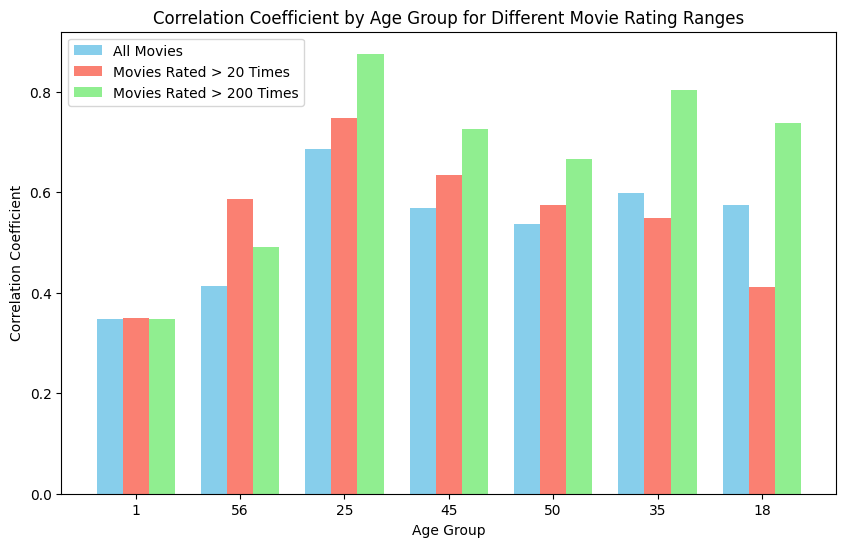

In [64]:
# Data for each scenario
age_groups = list(age_gender_correlations.keys())  # Age groups
all_movies_corr = list(age_gender_correlations.values())  # All Movies
movies_20_corr = list(correlation_by_age_moderate.values())  # Movies Rated > 20 Times
movies_200_corr = list(correlation_by_age_popular.values())  # Movies Rated > 200 Times

# Set up bar width and positions
bar_width = 0.25
x = np.arange(len(age_groups))

# Plot the grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, all_movies_corr, width=bar_width, label='All Movies', color='skyblue')
plt.bar(x, movies_20_corr, width=bar_width, label='Movies Rated > 20 Times', color='salmon')
plt.bar(x + bar_width, movies_200_corr, width=bar_width, label='Movies Rated > 200 Times', color='lightgreen')

# Add labels and title
plt.xlabel('Age Group')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficient by Age Group for Different Movie Rating Ranges')
plt.xticks(x, age_groups)  # Set x-ticks to age group names
plt.legend()
plt.show()

Generally, correlation coefficient increases for each age group when the number of ratings increases for each movie, solidifying our  concept that more data, more accurate result, and more accurate prediction.

In [65]:
# Dictionary to store the models for each age group
age_group_models = {}

# Perform linear regression for each age group
for age in age_groups:
    age_group_data = merged_df[merged_df['Age'] == age]
    
    # Filter movies with at least 10 ratings from each gender
    qualifying_movies = age_group_data.groupby('Title').filter(
        lambda x: (x[x['Gender'] == 'M'].shape[0] >= 10) and (x[x['Gender'] == 'F'].shape[0] >= 10)
    )
    
    # Calculate mean ratings and fit linear regression if sufficient data
    mean_ratings_men = qualifying_movies[qualifying_movies['Gender'] == 'M'].groupby('Title')['Rating'].mean()
    mean_ratings_women = qualifying_movies[qualifying_movies['Gender'] == 'F'].groupby('Title')['Rating'].mean()
    ratings_df = pd.DataFrame({'Men': mean_ratings_men, 'Women': mean_ratings_women}).dropna()

    if len(ratings_df) > 1:
        model = LinearRegression()
        model.fit(ratings_df['Men'].values.reshape(-1, 1), ratings_df['Women'].values)
        age_group_models[age] = model
        print(f"Model for age {age}: Intercept = {model.intercept_:.2f}, Slope = {model.coef_[0]:.2f}")

# Predict women's rating based on a men's rating of 4.0 for each age group
men_rating = 4.0
predictions = {}
for age, model in age_group_models.items():
    predicted_women_rating = model.predict(np.array([[men_rating]]))[0]
    predictions[age] = predicted_women_rating
    print(f"Predicted women’s rating for men’s rating of {men_rating} in age group {age}: {predicted_women_rating:.2f}")


Model for age 1: Intercept = 2.41, Slope = 0.37
Model for age 56: Intercept = 1.90, Slope = 0.56
Model for age 25: Intercept = 0.44, Slope = 0.89
Model for age 45: Intercept = 0.80, Slope = 0.78
Model for age 50: Intercept = 0.93, Slope = 0.77
Model for age 35: Intercept = 0.80, Slope = 0.78
Model for age 18: Intercept = 0.35, Slope = 0.87
Predicted women’s rating for men’s rating of 4.0 in age group 1: 3.90
Predicted women’s rating for men’s rating of 4.0 in age group 56: 4.13
Predicted women’s rating for men’s rating of 4.0 in age group 25: 4.00
Predicted women’s rating for men’s rating of 4.0 in age group 45: 3.93
Predicted women’s rating for men’s rating of 4.0 in age group 50: 4.02
Predicted women’s rating for men’s rating of 4.0 in age group 35: 3.94
Predicted women’s rating for men’s rating of 4.0 in age group 18: 3.84


In [66]:
# Setting up the plot size and layout for multiple age groups
num_plots = len(age_group_models)
fig, axes = plt.subplots(nrows=(num_plots // 3) + 1, ncols=3, figsize=(18, 10))
fig.suptitle("Prediction of Women’s Ratings Based on Men’s Ratings by Age Group", fontsize=16)

# Flatten axes for easy indexing
axes = axes.flatten()

# Plot each age group with its corresponding regression model
for idx, (age, model) in enumerate(age_group_models.items()):
    # Filter the data for the current age group
    age_group_data = merged_df[merged_df['Age'] == age]
    qualifying_movies = age_group_data.groupby('Title').filter(
        lambda x: (x[x['Gender'] == 'M'].shape[0] >= 10) and (x[x['Gender'] == 'F'].shape[0] >= 10)
    )
    
    # Calculate mean ratings by gender for each qualifying movie
    mean_ratings_men = qualifying_movies[qualifying_movies['Gender'] == 'M'].groupby('Title')['Rating'].mean()
    mean_ratings_women = qualifying_movies[qualifying_movies['Gender'] == 'F'].groupby('Title')['Rating'].mean()
    
    # Align the ratings data for plotting
    ratings_df = pd.DataFrame({'Men': mean_ratings_men, 'Women': mean_ratings_women}).dropna()

    # Scatter plot with regression line
    sns.scatterplot(x='Men', y='Women', data=ratings_df, ax=axes[idx], color='blue', s=20, label="Movie Ratings")
    
    # Plot the regression line
    x_vals = ratings_df['Men'].values.reshape(-1, 1)
    y_pred = model.predict(x_vals)
    axes[idx].plot(ratings_df['Men'], y_pred, color='red', linewidth=2, label="Regression Line")
    
    # Add labels and title
    axes[idx].set_title(f"Age Group {age}")
    axes[idx].set_xlabel("Men's Average Rating")
    axes[idx].set_ylabel("Women's Average Rating")
    axes[idx].legend()

# Adjust layout and hide any unused subplots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The regression lines help visualize the trend that, across age groups, men’s ratings can be used to predict women’s ratings with varying degrees of accuracy. The alignment between male and female ratings for movies remains generally consistent, but the strength of this alignment varies by age. The age groups 18, 25, and 35 have strong correlations, showing tightly clustered points around the line.

# Problem 4: (10 points total)
## Open Ended Question:  Business Intelligence

* Do any of your conjectures in Problems 1, 2, and 3 provide insights that a movie company might be interested in?
* Propose a business question that you think this data can answer. 
* Suppose you are a Data Scientist at a movie company.  **Convince your boss that your conjecture is correct!**



In problem 1, we explored various viewer characteristics, including age and gender, to draw insights about movie ratings. Our analysis indicated that women tend to give higher average ratings compared to men, with a significant number of movies receiving an average rating above 4.5 from female viewers.This means that a movie company may acquire advantages in marketing directly to female audiences. Fostering genres that end up more popular with women would increase aggregate ratings and Women on average give higher fives, if the win them over to like content for their gender voting group then you probably have moves working better universally.

In problem 2, we examined the extremity of ratings across different age groups. Our findings revealed that younger viewers, particularly those aged 1-18, are more likely to give extreme ratings of both 1 and 5. TIt clearly advances what movie companies have always understood, that there ismoney in Kids and Teens. The company can convert lower ratings into higher ones by building content catered to this demographic therefore further enhancing the businesses overall rating.

In problem 3, we investigated the correlation between male and female ratings. The strong positive correlation found for movies rated more than 200 times suggests that popular films tend to receive similar ratings from both genders. This information could guide the movie company in making genre-specific recommendations. For instance, if a fantasy movie is highly rated by men, it could be effectively marketed to women as well, increasing the likelihood of positive ratings across the board.Furthermore, recognizing that women are harder critics when it comes to rating movies will allow the company to tweak its tactics in order capture this section of the audience.
Overall, the insights gathered from our conjectures can assist the movie company in focusing on demographics that are harder to please, ultimately enhancing their ratings. This approach is vital for optimizing marketing efforts and improving audience engagement while managing costs.

A business question that can be answered by our data: “How can we strategically enhance our ratings while minimizing expenses?” Our analysis provides actionable insights that can help the company increase ratings without incurring additional costs. By leveraging the data, we can focus on producing content that appeals to specific viewer demographics, thereby optimizing ratings without expanding our budget. The goal is to effectively convert the ratings of critical viewers, which will ultimately lead to an increase in overall ratings.

This analysis of the MovieLens Data Set provided valuable insights into how different demographic groups influence movie ratings. We learned that females, on average, rate higher than males which is consistent with other research and also discovered the highest extremity in rating comes from younger audiences (age 1-18). In order to reach for Young People who was the top viewer age range which is under 35, University Promotions by doing so and Release Specifics Content Genres can be one of the potential solutions that could lead increased viewerships also Student Discounts with a platform distribution would give an impact more positively than before. Furthermore, it gives us a notion regarding the relationship of male and female ratings as to genre-specific recommendations that could not only benefit in increasing overall good-will for both genders.

To sum up, the use of demographic insights will make marketing more targeted and focus on stimulating engagement between audiences with higher preferences translating into better movie ratings. Advertising to key viewer segments will make its films appeal more acceptable and boost ratings overall without significant additional marketing spend.

# Report: communicate the results (15 points) 

Open ended. Should at least dicuss the following:

* What is the relationship between this topic and Business Intelligence?
    * How did you analyse the data?
    * What did you find in the data? 
    * What conjectures did you make and how did you support or disprove them using data?
    * Did you find anything suprising in the data?
    * What business decision do you think this data could help answer? Why?
    * The story of the group: How did each member help the group? This section should appear at the end and can essentially tell a story of how the case study started, the issues faced, how each member played a role and helped solve specific problems. ETC. ETC.
    
**Note**: Please include figures or tables in the report (**but no source code**). Should be minimum 8 pages.

# Slides (for 10 minutes of presentation) (15 points)


1. (3 points) Motivation about the data collection, why the topic is interesting to you. 

2. (8 points) Communicating Results (figure/table)

3. (4 points) Story telling (How all the parts (data, analysis, result) fit together as a story?)'

**Note**: Three teams will be randomly chosen to present in the class.

# Done

All set! 

**What do you need to submit?**

* **Notebook File**: Save this IPython notebook, and find the notebook file in your folder (for example, "groupname.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook.

* **PPT Slides**

* **Report**

Put the Jupyter Notebook file, the report (in PDF) and PPT slides (converted to PDF) in a folder. Zip the folder. After zipping, it should have the extension .zip. The name of the .zip file should be casestudy_3_groupname.zip. Upload the .zip file on Canvas.
        
**Note: Each team just needs to make one submission**